In [ ]:
!pip install klib
!pip install sweetviz
import pandas as pd
import numpy as np
import klib
#import pandas_profiling as pp
import sweetviz
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 28.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
file_path = "Traffic_Crashes_2019-2022.csv"

df = pd.read_csv(file_path)
df.head()

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,367490fad73ad47e7c570928f719c506c645fbf2099e14...,JG101906,Y,12/31/2022 23:59,20,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,...,0.0,0.0,1.0,0.0,23.0,7.0,12.0,41.937900,-87.792173,POINT (-87.792172645485 41.937899604146)
1,538cc213046ff7600cd3586a2ddd41c5b48f76f6ff5225...,JG103534,NaN,12/31/2022 23:55,20,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,PARKED MOTOR VEHICLE,...,1.0,0.0,1.0,0.0,23.0,7.0,12.0,41.912074,-87.775463,POINT (-87.775462841928 41.912074060728)
2,c05d09cfbb00c98d0890811b21cec65fefef70900c1d60...,JG100046,NaN,12/31/2022 23:52,15,UNKNOWN,UNKNOWN,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,...,0.0,0.0,6.0,0.0,23.0,7.0,12.0,41.962269,-87.634734,POINT (-87.634734438748 41.962269169487)
3,5e5667bedce936fb6768c48cd1d1d71af618061fe0e476...,JG102768,NaN,12/31/2022 23:45,30,UNKNOWN,UNKNOWN,UNKNOWN,DARKNESS,PARKED MOTOR VEHICLE,...,0.0,0.0,1.0,0.0,23.0,7.0,12.0,41.744200,-87.566268,POINT (-87.566268248099 41.744200188109)
4,70741202005e9dc65235b75cc964f49922cf0b2739a70e...,JG100137,NaN,12/31/2022 23:45,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,...,0.0,0.0,1.0,0.0,23.0,7.0,12.0,41.732755,-87.643378,POINT (-87.643378250291 41.732755134892)


In [ ]:
# Converting column names to lower
df.columns = df.columns.str.lower()

# Rename long columns
df_1 = df.rename(columns={
    'injuries_non_incapacitating':'inj_non_incap',
    'injuries_reported_not_evident':'inj_report_not_evdnt'
})
# Drop unwanted columns
df_1.drop(columns=[
    'rd_no','crash_date_est_i','lane_cnt','location','report_type', 'date_police_notified',
    'photos_taken_i','statements_taken_i','dooring_i','work_zone_i','work_zone_type','workers_present_i',
#    'intersection_related_i','not_right_of_way_i','hit_and_run_i', # don't drop these anymore
], inplace=True)

In [ ]:
# Clean and standardize column names
df_c = klib.clean_column_names(df_1)

GridSpec(6, 6)

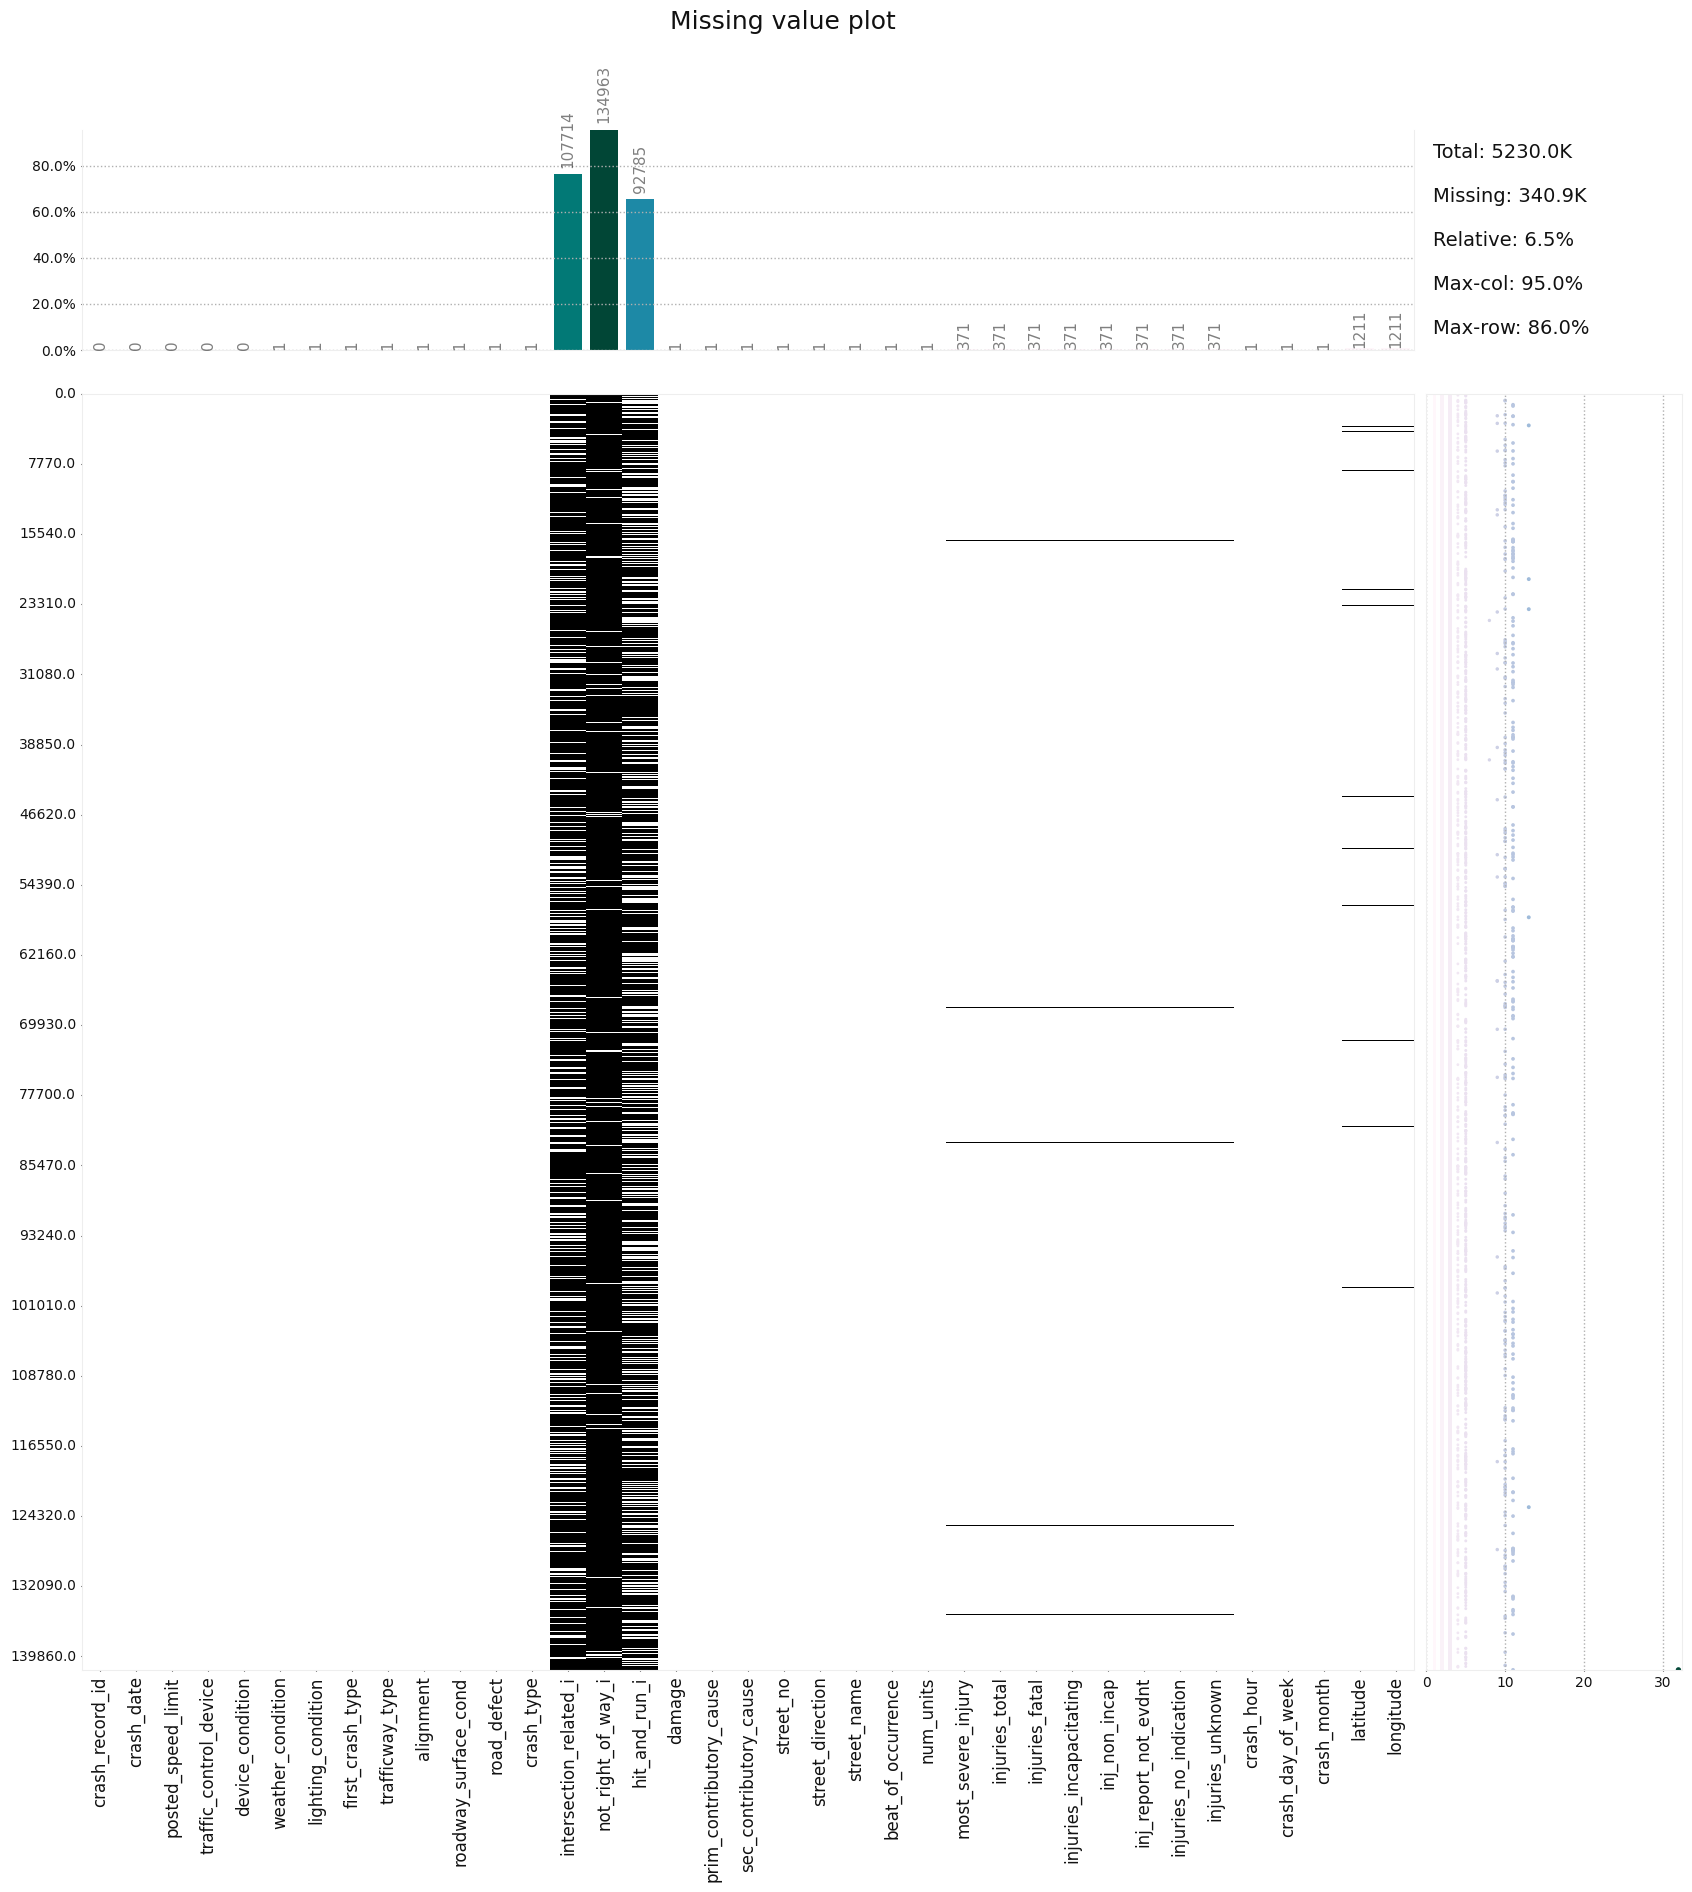

In [ ]:
klib.missingval_plot(df_c)

In [ ]:
# Fill missing values in these columns with N value, assuming it's the default
df_c.fillna({
    'intersection_related_i':'N',
    'not_right_of_way_i':'N',
    'hit_and_run_i':'N'
}, inplace=True)

GridSpec(6, 6)

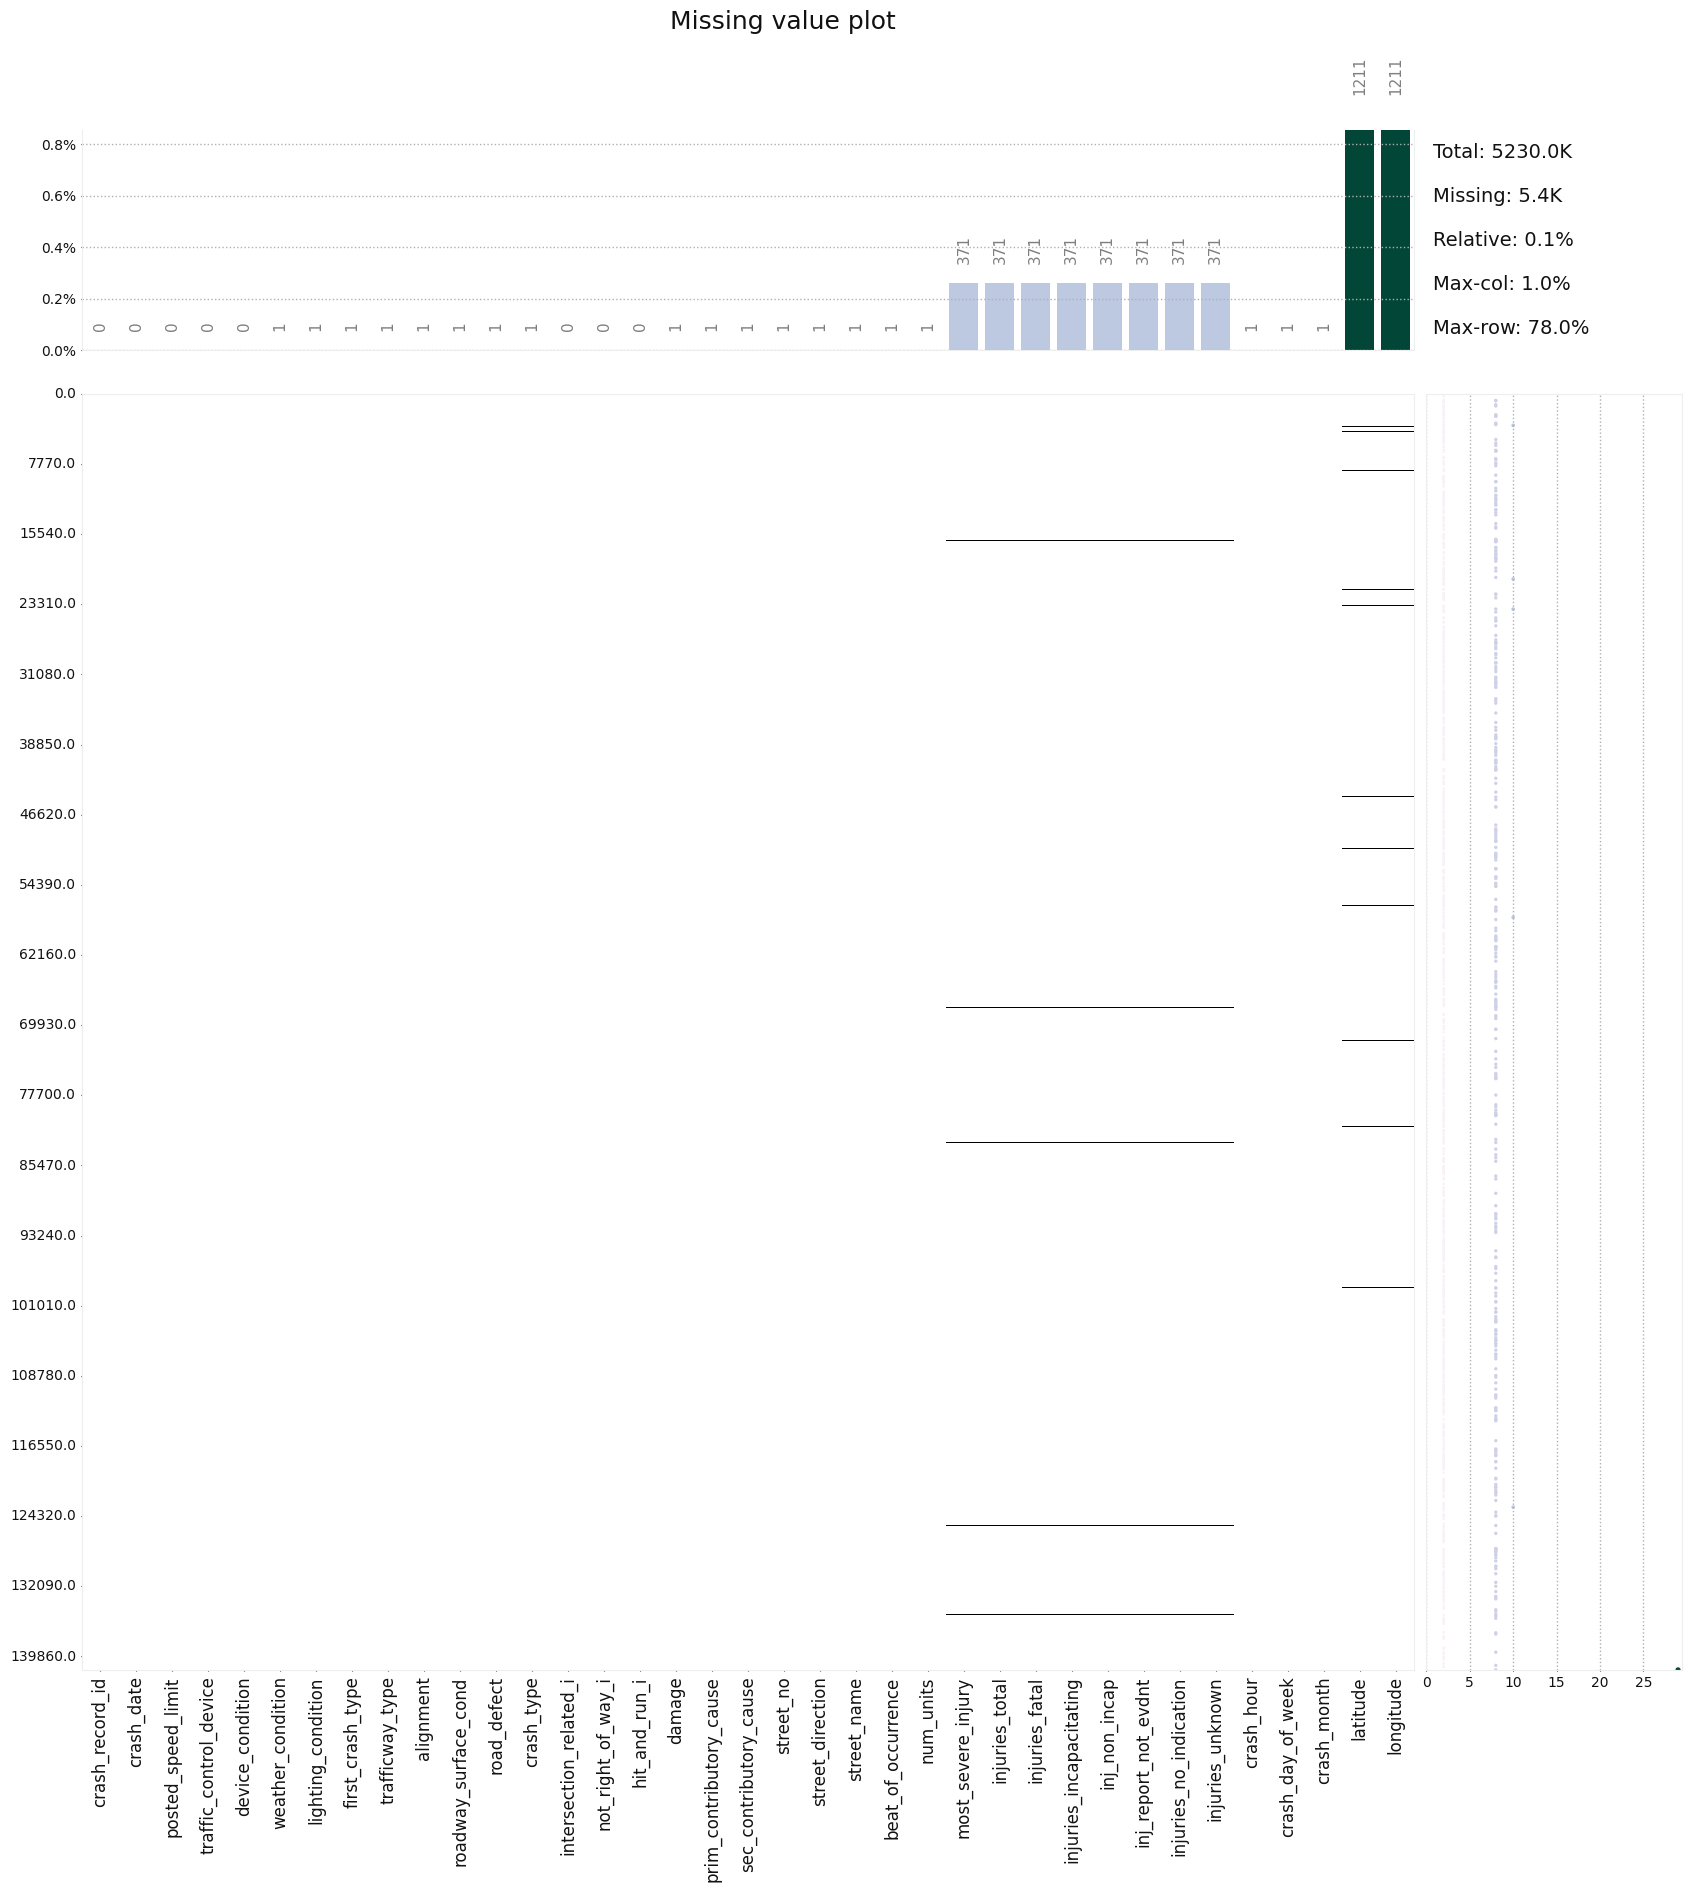

In [ ]:
klib.missingval_plot(df_c)

In [ ]:
# Set these columns to 0 wherever injuries_total is missing and crash_type is no injury
df_c.loc[((df_c.injuries_total.isna()) & (df_c.crash_type == 'NO INJURY / DRIVE AWAY')),[
          'injuries_total',
          'injuries_fatal',
          'injuries_incapacitating',
          'inj_non_incap',
          'inj_report_not_evdnt',
          'injuries_no_indication',
          'injuries_unknown'
         ]] = 0

In [ ]:
# Drop rows where injuries_total is missing
df_c.drop(df_c[df_c.injuries_total.isna()].index, inplace=True)

In [ ]:
# Set most_severe_injury = NO INDICATION OF INJURY,
# wherever most_severe_injury is missing and injuries_total is 0
df_c.loc[(df_c.most_severe_injury.isna()) & (df_c.injuries_total == 0),'most_severe_injury'] = 'NO INDICATION OF INJURY'

In [ ]:
df_c.most_severe_injury.value_counts(dropna=False)

NO INDICATION OF INJURY     120146
NONINCAPACITATING INJURY     12234
REPORTED, NOT EVIDENT         6054
INCAPACITATING INJURY         2553
FATAL                          191
Name: most_severe_injury, dtype: int64

GridSpec(6, 6)

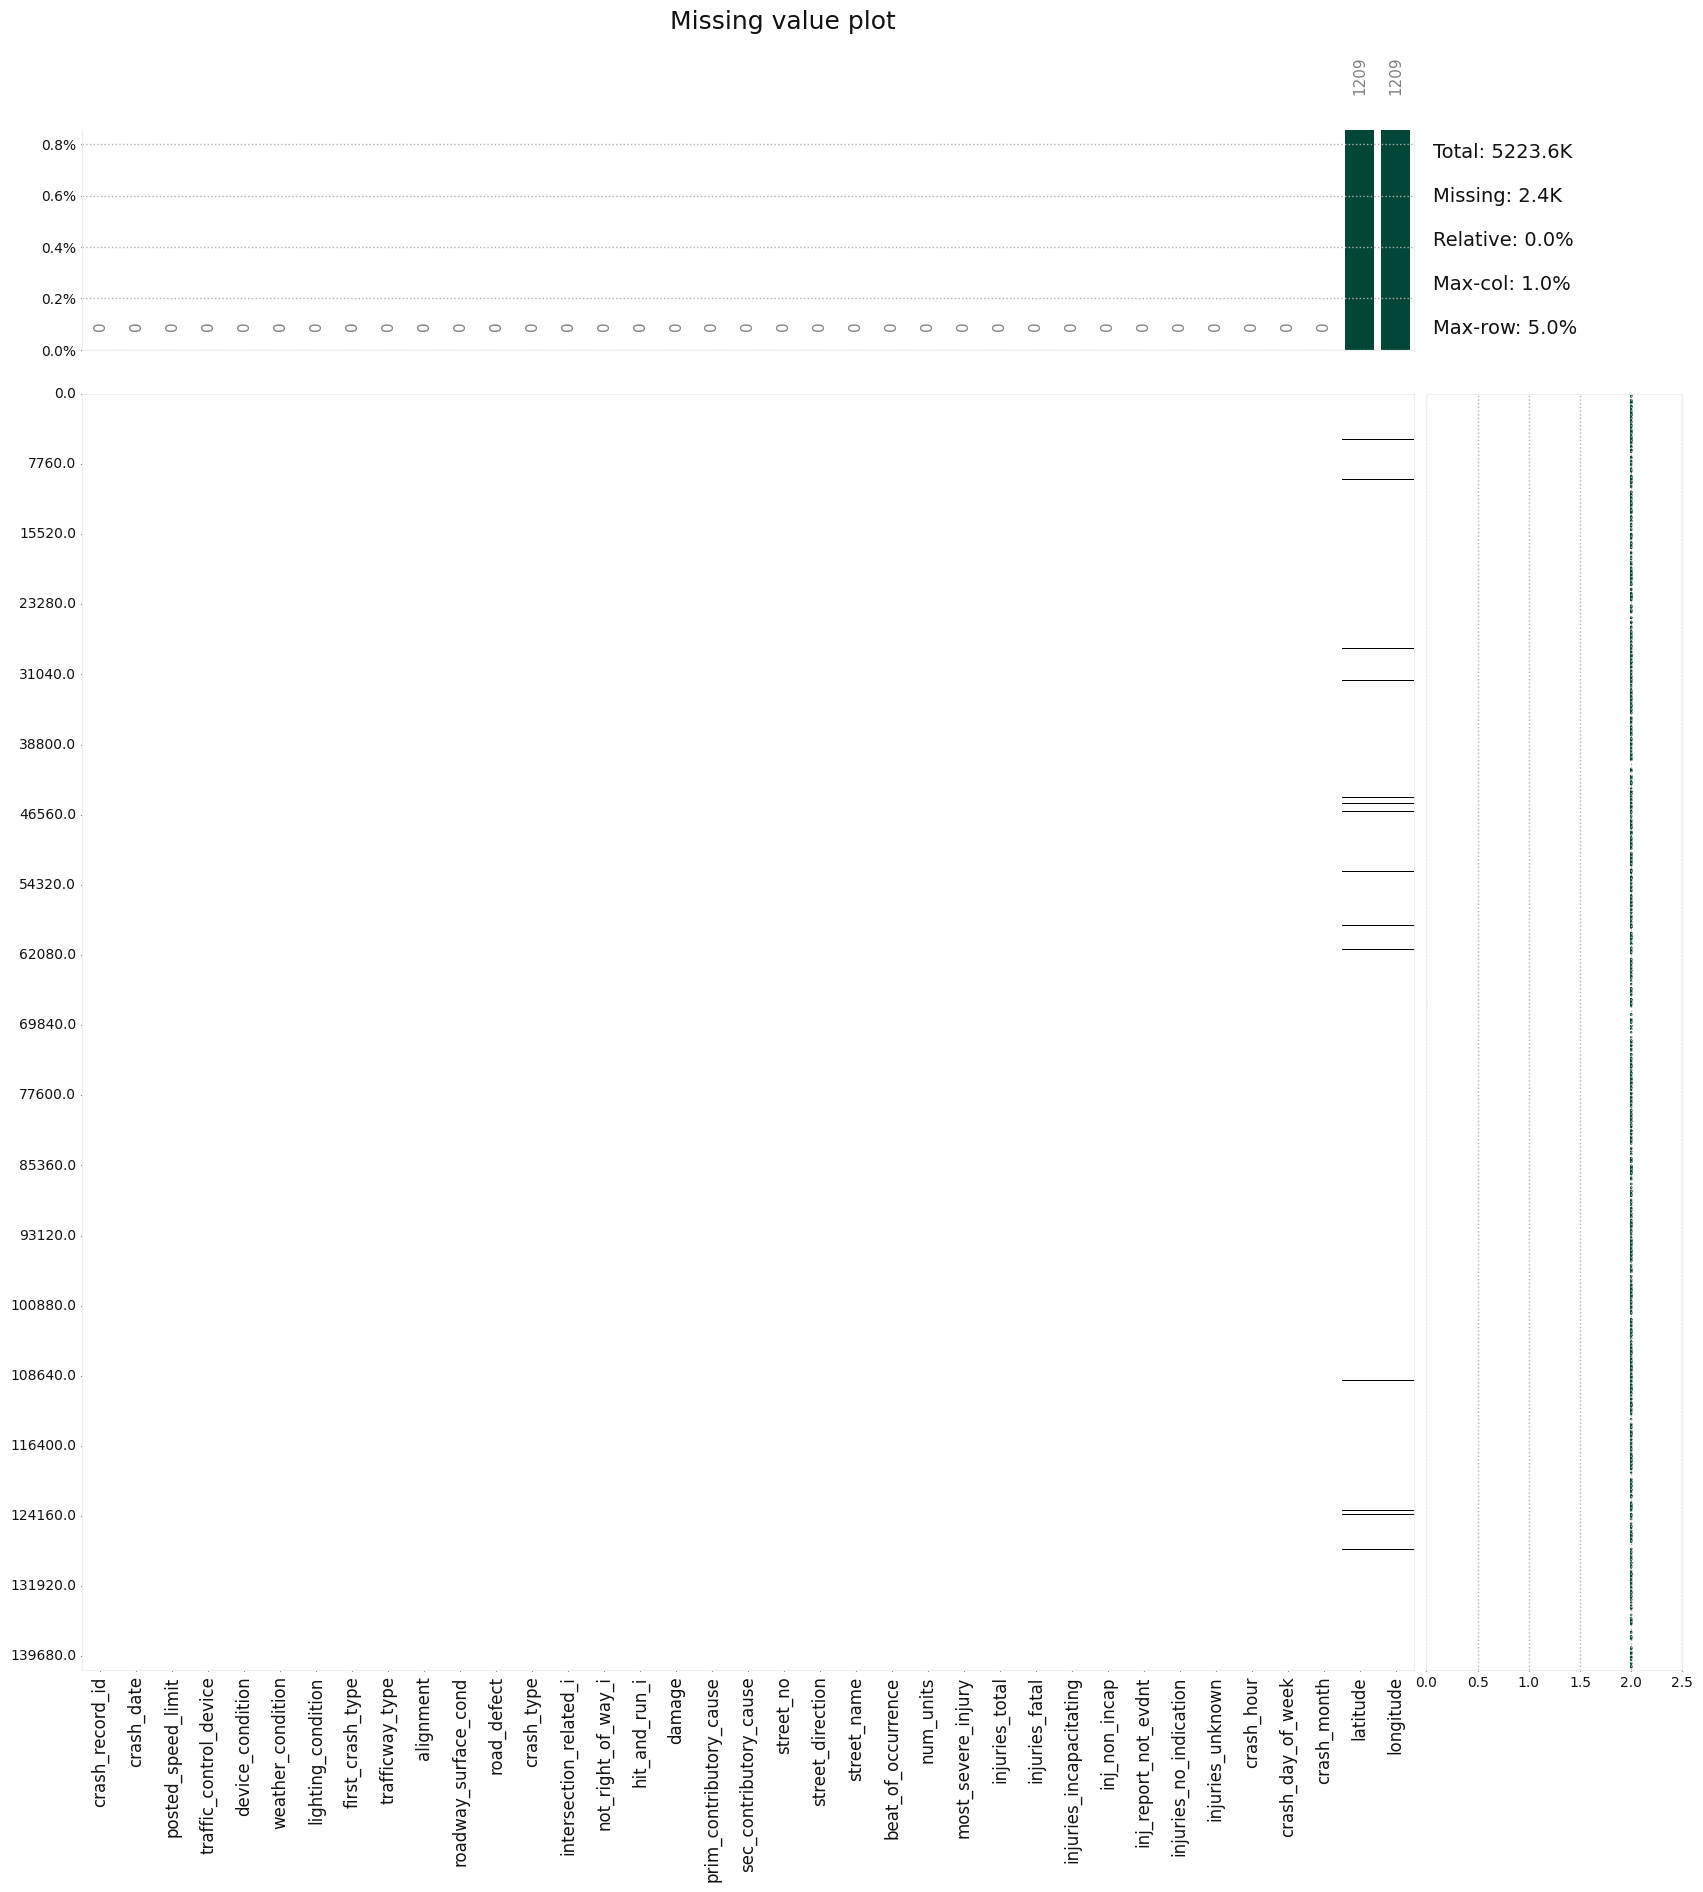

In [ ]:
klib.missingval_plot(df_c)


In [ ]:
# Convert 'crash_date' column to datetime
df_c['crash_date'] = pd.to_datetime(df_c['crash_date'])

# Extract year from 'crash_date' column
df_c['crash_year'] = df_c['crash_date'].dt.year

# create address column
#crashes_df2['street_no'] = (crashes_df2['street_no']//100*100).astype(str)
df_c['street_no'] = (df_c['street_no']).astype(str)
df_c['street_direction'] = (df_c['street_direction']).astype(str)
df_c['street_name'] = (df_c['street_name']).astype(str)
df_c['address'] = df_c[['street_no', 'street_direction', 'street_name']].agg(' '.join, axis=1)

In [ ]:
# I will not drop duplicates, as they represent repeated incident characteristics, I think it's useful
df_c2 = klib.data_cleaning(df_c, drop_duplicates=False)

Shape of cleaned data: (141178, 38) - Remaining NAs: 2418


Dropped rows: 0
     of which 0 duplicates. (Rows (first 150 shown): [])

Dropped columns: 1
     of which 1 single valued.     Columns: ['injuries_unknown']
Dropped missing values: 0
Reduced memory by at least: 31.59 MB (-67.04%)



In [ ]:
# drop rows that have both long and lat == 0
df_c2 = df_c2.query('latitude != 0 and longitude !=0')

In [ ]:
# At this point, Drop any rows that still has NA's
df_c2.dropna(axis=0, inplace=True)

In [ ]:
# Fix floats that should be int after we got rid of NA values
df_c2.beat_of_occurrence = df_c2.beat_of_occurrence.astype(int)
df_c2.injuries_total = df_c2.injuries_total.astype(int)
df_c2.injuries_fatal = df_c2.injuries_fatal.astype(int)
df_c2.injuries_incapacitating = df_c2.injuries_incapacitating.astype(int)
df_c2.inj_non_incap = df_c2.inj_non_incap.astype(int)
df_c2.inj_report_not_evdnt = df_c2.inj_report_not_evdnt.astype(int)
df_c2.injuries_no_indication = df_c2.injuries_no_indication.astype(int)

In [ ]:
df_c2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 139963 entries, 0 to 141350
Data columns (total 38 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   crash_record_id          139963 non-null  string        
 1   crash_date               139963 non-null  datetime64[ns]
 2   posted_speed_limit       139963 non-null  int8          
 3   traffic_control_device   139963 non-null  category      
 4   device_condition         139963 non-null  category      
 5   weather_condition        139963 non-null  category      
 6   lighting_condition       139963 non-null  category      
 7   first_crash_type         139963 non-null  category      
 8   trafficway_type          139963 non-null  category      
 9   alignment                139963 non-null  category      
 10  roadway_surface_cond     139963 non-null  category      
 11  road_defect              139963 non-null  category      
 12  crash_type      

In [ ]:
klib.missingval_plot(df_c2)


No missing values found in the dataset.


In [ ]:
_unit = 5 # rounding at mid-point to nearest _unit
df_c2.posted_speed_limit = df_c2.posted_speed_limit.apply(lambda x: (x//_unit*_unit) + round(x%_unit/_unit)*_unit)
df_c2.posted_speed_limit.value_counts()

30    103351
25      9383
35      8867
20      6416
15      4801
10      3573
40      1542
45      1065
5        458
0        321
55       123
50        49
60        11
65         2
70         1
Name: posted_speed_limit, dtype: int64

In [ ]:
df_c2['has_injuries'] = df_c2.injuries_total.apply(lambda x: int(x>0))
df_c2['has_injuries'].value_counts()

0    119073
1     20890
Name: has_injuries, dtype: int64

In [ ]:
df_c2['has_fatal'] = df_c2.injuries_fatal.apply(lambda x: int(x>0))
df_c2['has_fatal'].value_counts()

0    139774
1       189
Name: has_fatal, dtype: int64

In [ ]:
df_c2['crash_time_of_day'] = pd.cut(df_c2.crash_hour, bins=[-np.inf,6,12,18,np.inf], labels=['overnight','morning','mid_day','evening'])
df_c2['crash_time_of_day'].value_counts()

crash_df = df_c2

# **Exploratory Data Analysis**


In [ ]:
[*crash_df.columns]

['crash_record_id',
 'crash_date',
 'posted_speed_limit',
 'traffic_control_device',
 'device_condition',
 'weather_condition',
 'lighting_condition',
 'first_crash_type',
 'trafficway_type',
 'alignment',
 'roadway_surface_cond',
 'road_defect',
 'crash_type',
 'intersection_related_i',
 'not_right_of_way_i',
 'hit_and_run_i',
 'damage',
 'prim_contributory_cause',
 'sec_contributory_cause',
 'street_no',
 'street_direction',
 'street_name',
 'beat_of_occurrence',
 'num_units',
 'most_severe_injury',
 'injuries_total',
 'injuries_fatal',
 'injuries_incapacitating',
 'inj_non_incap',
 'inj_report_not_evdnt',
 'injuries_no_indication',
 'crash_hour',
 'crash_day_of_week',
 'crash_month',
 'latitude',
 'longitude',
 'crash_year',
 'address',
 'has_injuries',
 'has_fatal',
 'crash_time_of_day']

In [ ]:
features_names = [
    'crash_date',
    'crash_year',
    'crash_month',
    'crash_day_of_week',
    'crash_hour',
    'crash_time_of_day', # New
    'latitude',
    'longitude',
    'beat_of_occurrence',
    'address',
    'posted_speed_limit',
    'traffic_control_device',
    'device_condition',
    'weather_condition',
    'lighting_condition',
    'trafficway_type',
    'alignment',
    'roadway_surface_cond',
    'road_defect',
    'first_crash_type',
    'prim_contributory_cause',
    'sec_contributory_cause',
    'num_units'
]

target_names = [
    'has_injuries',  # New
    'has_fatal',  # New
    'crash_type',
    'damage',
    'injuries_total',
    'injuries_fatal'
]

all_columns = features_names + target_names
all_columns

['crash_date',
 'crash_year',
 'crash_month',
 'crash_day_of_week',
 'crash_hour',
 'crash_time_of_day',
 'latitude',
 'longitude',
 'beat_of_occurrence',
 'address',
 'posted_speed_limit',
 'traffic_control_device',
 'device_condition',
 'weather_condition',
 'lighting_condition',
 'trafficway_type',
 'alignment',
 'roadway_surface_cond',
 'road_defect',
 'first_crash_type',
 'prim_contributory_cause',
 'sec_contributory_cause',
 'num_units',
 'has_injuries',
 'has_fatal',
 'crash_type',
 'damage',
 'injuries_total',
 'injuries_fatal']

In [ ]:
crash_df.posted_speed_limit.value_counts()

30    103351
25      9383
35      8867
20      6416
15      4801
10      3573
40      1542
45      1065
5        458
0        321
55       123
50        49
60        11
65         2
70         1
Name: posted_speed_limit, dtype: int64

In [ ]:
crash_df.posted_speed_limit.round(-1).value_counts() # rounding down to nearest 10

30    103351
20     20600
40     11474
10      3573
0        779
60       136
50        49
70         1
Name: posted_speed_limit, dtype: int64

In [ ]:
crash_df.posted_speed_limit.apply(lambda x: (x//10*10) + round(x%10/10)*10).value_counts() # rounding at mid-point to nearest 10

30    112218
20     15799
10      8374
40      2607
0        779
50       172
60        13
70         1
Name: posted_speed_limit, dtype: int64

In [ ]:
crash_df.posted_speed_limit.apply(lambda x: (x//5*5) + round(x%5/5)*5).value_counts() # rounding to nearest 5

30    103351
25      9383
35      8867
20      6416
15      4801
10      3573
40      1542
45      1065
5        458
0        321
55       123
50        49
60        11
65         2
70         1
Name: posted_speed_limit, dtype: int64

In [ ]:
crash_df.beat_of_occurrence.nunique()

271

In [ ]:
crash_df.address.nunique()

88891

In [ ]:
crash_df.groupby(['latitude','longitude']).size().reset_index(name='n')

,latitude,longitude,n
0,41.644669,-87.540092,4
1,41.644711,-87.614296,1
2,41.644714,-87.612823,2
3,41.644718,-87.606796,1
4,41.644722,-87.614349,1
...,...,...,...
86114,42.022633,-87.671181,1
86115,42.022644,-87.673653,2
86116,42.022644,-87.673271,1
86117,42.022659,-87.676651,3


In [ ]:
crash_df.crash_type.value_counts()

NO INJURY / DRIVE AWAY              98400
INJURY AND / OR TOW DUE TO CRASH    41563
Name: crash_type, dtype: int64

In [ ]:
crash_df.injuries_total.apply(lambda x: int(x>0)).value_counts()

0    119073
1     20890
Name: injuries_total, dtype: int64

In [ ]:
crash_df.injuries_fatal.apply(lambda x: int(x>0)).value_counts()

0    139774
1       189
Name: injuries_fatal, dtype: int64

In [ ]:
crash_df.first_crash_type.value_counts()

PARKED MOTOR VEHICLE            32934
REAR END                        28540
TURNING                         20793
SIDESWIPE SAME DIRECTION        20644
ANGLE                           15920
FIXED OBJECT                     6930
PEDESTRIAN                       3270
PEDALCYCLIST                     2120
REAR TO FRONT                    2087
SIDESWIPE OPPOSITE DIRECTION     1848
OTHER OBJECT                     1506
REAR TO SIDE                     1173
HEAD ON                          1150
OTHER NONCOLLISION                438
REAR TO REAR                      408
ANIMAL                            100
OVERTURNED                         96
TRAIN                               6
Name: first_crash_type, dtype: int64

In [ ]:
crash_df.trafficway_type.value_counts()

NOT DIVIDED                        60483
DIVIDED - W/MEDIAN (NOT RAISED)    19162
ONE-WAY                            16545
FOUR WAY                           14117
PARKING LOT                         8626
DIVIDED - W/MEDIAN BARRIER          7673
OTHER                               3476
T-INTERSECTION                      2831
ALLEY                               2271
UNKNOWN                             1588
CENTER TURN LANE                     691
UNKNOWN INTERSECTION TYPE            606
RAMP                                 398
DRIVEWAY                             381
Y-INTERSECTION                       287
FIVE POINT, OR MORE                  282
TRAFFIC ROUTE                        249
NOT REPORTED                         190
ROUNDABOUT                            58
L-INTERSECTION                        49
Name: trafficway_type, dtype: int64

In [ ]:
crash_df.prim_contributory_cause.value_counts()

UNABLE TO DETERMINE                                                                 58784
FAILING TO YIELD RIGHT-OF-WAY                                                       15328
FOLLOWING TOO CLOSELY                                                               11871
IMPROPER OVERTAKING/PASSING                                                          7142
NOT APPLICABLE                                                                       6777
FAILING TO REDUCE SPEED TO AVOID CRASH                                               5755
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  4871
IMPROPER TURNING/NO SIGNAL                                                           4612
IMPROPER BACKING                                                                     4583
IMPROPER LANE USAGE                                                                  4564
DISREGARDING TRAFFIC SIGNALS                                                         3052
WEATHER   

In [ ]:
crash_df.sec_contributory_cause.value_counts()

NOT APPLICABLE                                                                      57365
UNABLE TO DETERMINE                                                                 53015
FAILING TO REDUCE SPEED TO AVOID CRASH                                               4517
FAILING TO YIELD RIGHT-OF-WAY                                                        4481
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  4037
FOLLOWING TOO CLOSELY                                                                3364
IMPROPER OVERTAKING/PASSING                                                          2138
IMPROPER LANE USAGE                                                                  1961
WEATHER                                                                              1547
IMPROPER TURNING/NO SIGNAL                                                           1492
IMPROPER BACKING                                                                      986
OPERATING 

In [ ]:
crash_df.traffic_control_device.value_counts()

NO CONTROLS                 78653
TRAFFIC SIGNAL              38722
STOP SIGN/FLASHER           14084
UNKNOWN                      6403
OTHER                        1082
YIELD                         200
OTHER REG. SIGN               155
PEDESTRIAN CROSSING SIGN      132
OTHER WARNING SIGN             96
RAILROAD CROSSING GATE         89
DELINEATORS                    81
SCHOOL ZONE                    80
FLASHING CONTROL SIGNAL        67
POLICE/FLAGMAN                 44
RR CROSSING SIGN               31
OTHER RAILROAD CROSSING        30
NO PASSING                     12
BICYCLE CROSSING SIGN           2
Name: traffic_control_device, dtype: int64

In [ ]:
crash_df.injuries_total.describe()

count    139963.000000
mean          0.204704
std           0.581481
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          21.000000
Name: injuries_total, dtype: float64

# Define Weekdays

In [ ]:
week_days = {0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'}
is_weekday = {0:'Weekend',1:'Weekday'}

# Crash Hour Analysis

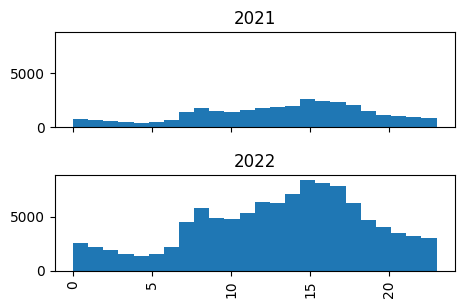

In [ ]:
# Crashes
crash_df.hist('crash_hour',bins=24,by='crash_year',layout=(4,1),figsize=(5,7),sharey=True,sharex=True);

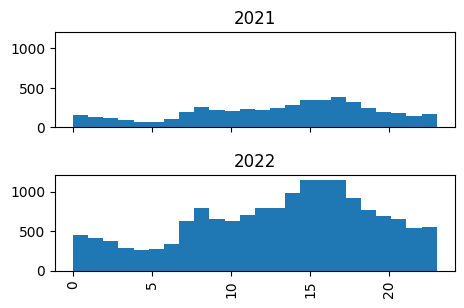

In [ ]:
# Crahes that has injuries
crash_df.query('has_injuries == 1').hist('crash_hour',bins=24,by='crash_year',layout=(4,1),figsize=(5,7),sharey=True,sharex=True);

In [ ]:
z = pd.cut(crash_df.crash_hour, bins=[-np.inf,6,12,18,np.inf], labels=['overnight','morning','mid_day','evening'])

In [ ]:
z

0         evening
1         evening
2         evening
3         evening
4         evening
           ...   
141346    evening
141347    evening
141348    evening
141349    evening
141350    evening
Name: crash_hour, Length: 139963, dtype: category
Categories (4, object): ['overnight' < 'morning' < 'mid_day' < 'evening']

In [ ]:
z.value_counts()

mid_day      57345
morning      41222
evening      23979
overnight    17417
Name: crash_hour, dtype: int64

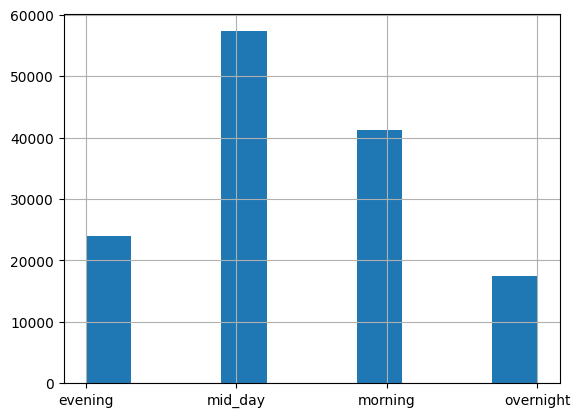

In [ ]:
z.hist();

In [ ]:
crash_df.crash_hour.isna().sum()

0

In [ ]:
z.isna().sum()

0

In [ ]:
crash_df.crash_hour.describe()

count    139963.000000
mean         13.092839
std           5.678145
min           0.000000
25%           9.000000
50%          14.000000
75%          17.000000
max          23.000000
Name: crash_hour, dtype: float64

# Analaysis

Let's try out some aggreggations

In [ ]:
crash_agg = crash_df.groupby([
    'crash_year',
    'crash_month',
#    'crash_day_of_week',
    'crash_hour',
#    'weather_condition'
]).agg({
    'injuries_total':np.sum,
    'injuries_fatal':np.sum
}
).fillna(0).reset_index()
crash_agg

,crash_year,crash_month,crash_hour,injuries_total,injuries_fatal
0,2021,9.0,0.0,26,0
1,2021,9.0,1.0,25,1
2,2021,9.0,2.0,31,1
3,2021,9.0,3.0,13,1
4,2021,9.0,4.0,7,0
...,...,...,...,...,...
379,2022,12.0,19.0,88,2
380,2022,12.0,20.0,75,1
381,2022,12.0,21.0,80,0
382,2022,12.0,22.0,62,1


In [ ]:
crash_agg.pivot_table(index=['crash_month'],columns='crash_year',values=['injuries_total','injuries_fatal'],aggfunc='sum')

injuries_fatal       injuries_total        
crash_year            2021  2022           2021    2022
crash_month                                            
1.0                    NaN  12.0            NaN  1419.0
2.0                    NaN  14.0            NaN  1371.0
3.0                    NaN  11.0            NaN  1600.0
4.0                    NaN  11.0            NaN  1693.0
5.0                    NaN   9.0            NaN  2014.0
6.0                    NaN   8.0            NaN  2218.0
7.0                    NaN  18.0            NaN  2191.0
8.0                    NaN  12.0            NaN  1911.0
9.0                   11.0  16.0         1184.0  2016.0
10.0                  13.0  12.0         2108.0  2038.0
11.0                  19.0  10.0         1735.0  1762.0
12.0                  17.0  17.0         1680.0  1711.0

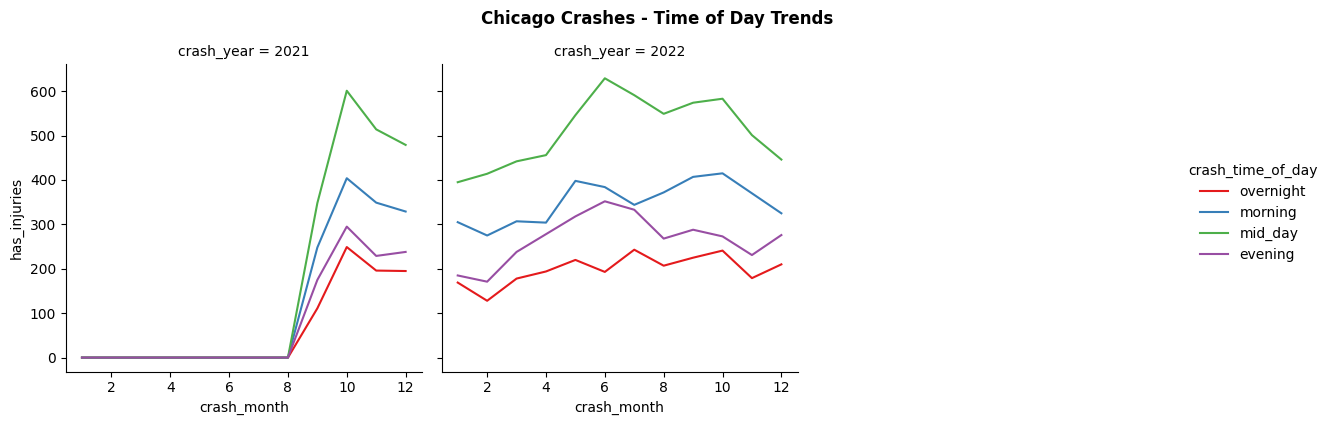

In [ ]:
crash_agg = crash_df.groupby([
    'crash_year',
    'crash_month',
#    'crash_day_of_week',
#    'crash_hour',
    'crash_time_of_day',
#    'weather_condition'
]).agg({
    'has_injuries':np.sum,
    'has_fatal':np.sum,
    'injuries_total':np.sum,
    'injuries_fatal':np.sum
}
).fillna(0).reset_index()

g = sns.FacetGrid(crash_agg, col='crash_year', hue='crash_time_of_day', palette='Set1', col_wrap=3, height=4)
g.map_dataframe(sns.lineplot,'crash_month', 'has_injuries')
g.fig.suptitle('Chicago Crashes - Time of Day Trends', y=1.05, fontweight='bold')
g.add_legend();

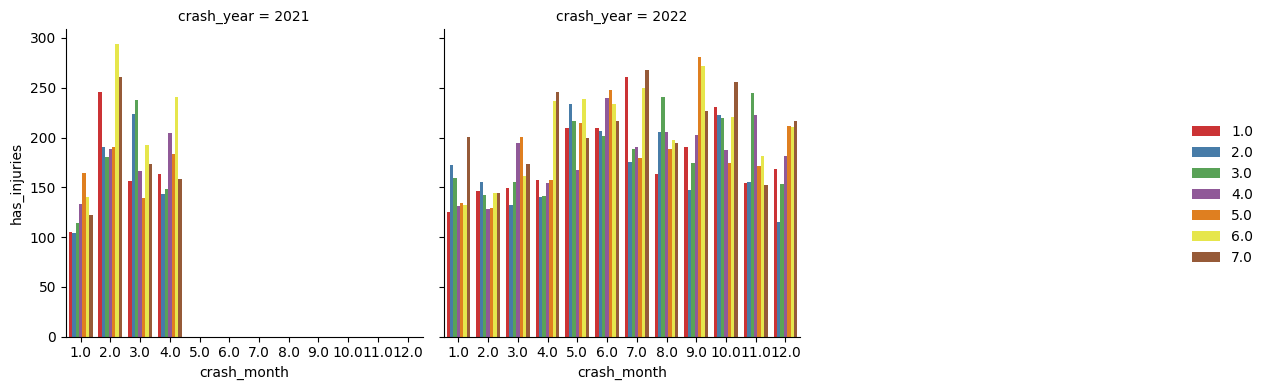

In [ ]:
crash_agg = crash_df.groupby([
    'crash_year',
    'crash_month',
    'crash_day_of_week',
#    'crash_hour',
#    'weather_condition'
]).agg({
    'has_injuries':np.sum,
    'injuries_total':np.sum,
    'injuries_fatal':np.sum
}
).fillna(0).reset_index()

g = sns.FacetGrid(crash_agg, col='crash_year',  col_wrap=3, height=4)
g.map_dataframe(sns.barplot,'crash_month','has_injuries',hue='crash_day_of_week',palette='Set1',)
g.add_legend();

In [ ]:
(crash_df.weather_condition == 'OTHER').sum()

483

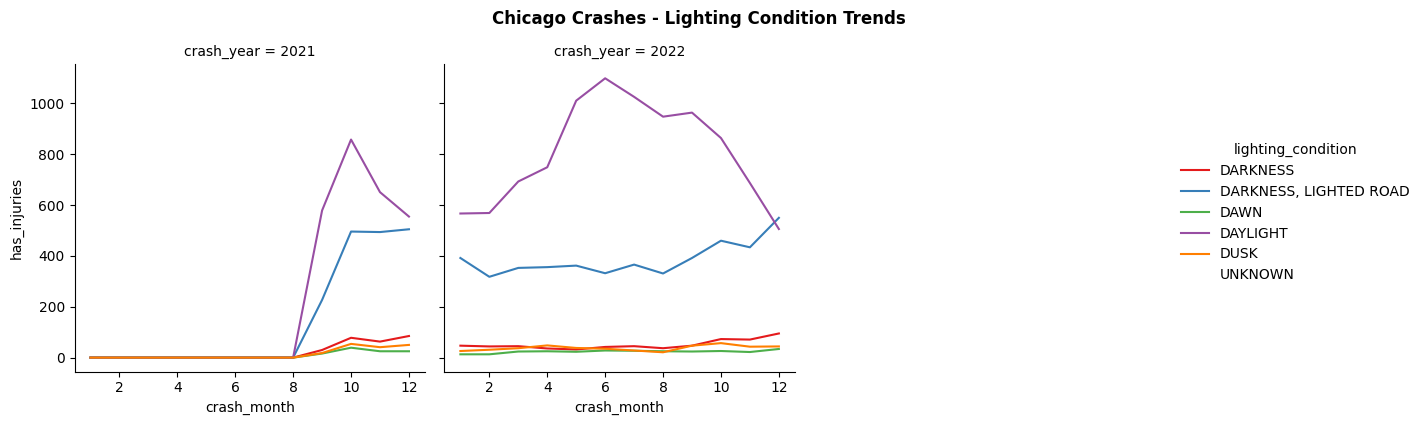

In [ ]:
crash_agg = crash_df.groupby([
    'crash_year',
    'crash_month',
#    'crash_day_of_week',
#    'crash_hour',
    'lighting_condition'
]).agg({
    'has_injuries':np.sum,
    'injuries_total':np.sum,
    'injuries_fatal':np.sum
}
).fillna(0).reset_index().query('lighting_condition not in ["UNKNOWN"]')

g = sns.FacetGrid(crash_agg, col='crash_year', hue='lighting_condition', palette='Set1', col_wrap=3, height=4)
g.map_dataframe(sns.lineplot,'crash_month', 'has_injuries')
g.fig.suptitle('Chicago Crashes - Lighting Condition Trends', y=1.05, fontweight='bold')
g.add_legend();

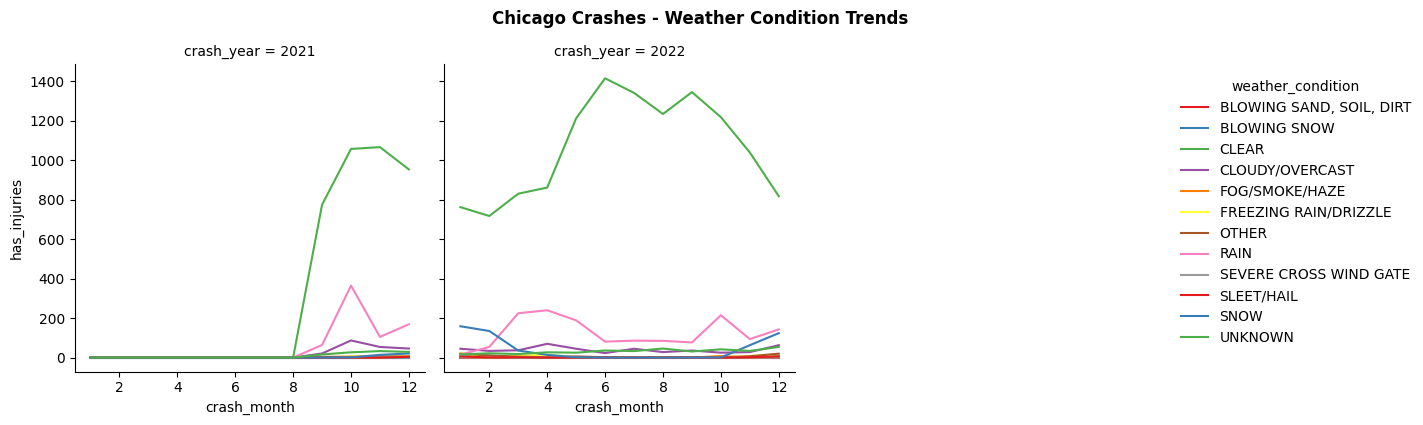

In [ ]:
crash_agg = crash_df.groupby([
    'crash_year',
    'crash_month',
#    'crash_day_of_week',
#    'crash_hour',
    'weather_condition'
]).agg({
    'has_injuries':np.sum,
    'injuries_total':np.sum,
    'injuries_fatal':np.sum
}
).fillna(0).reset_index()#.query('weather_condition not in ["CLEAR"]')

g = sns.FacetGrid(crash_agg, col='crash_year', hue='weather_condition', palette='Set1', col_wrap=3, height=4)
g.map_dataframe(sns.lineplot,'crash_month', 'has_injuries')
g.fig.suptitle('Chicago Crashes - Weather Condition Trends', y=1.05, fontweight='bold')
g.add_legend();

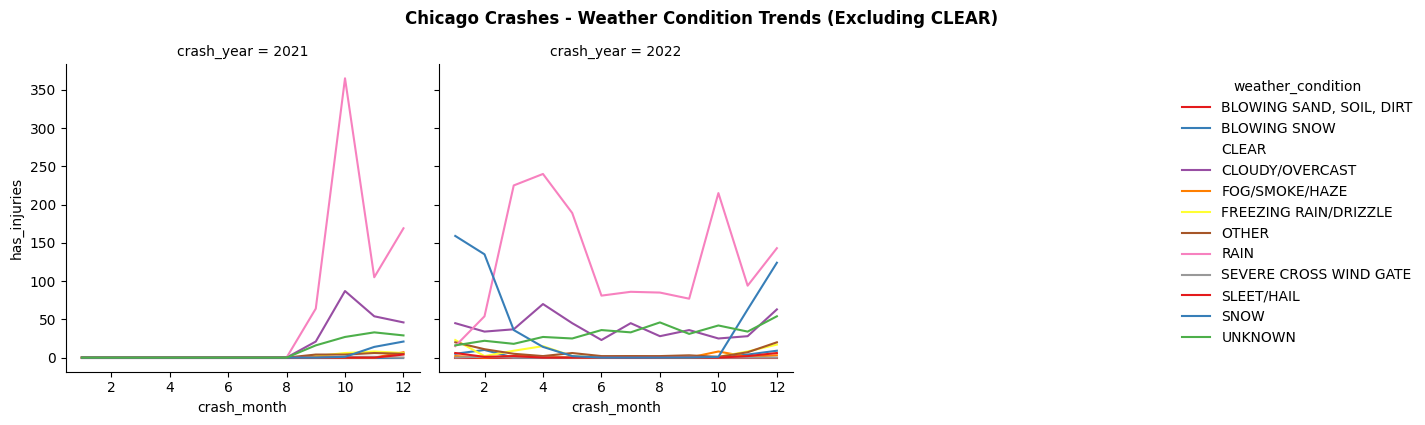

In [ ]:
crash_agg = crash_df.groupby([
    'crash_year',
    'crash_month',
#    'crash_day_of_week',
#    'crash_hour',
    'weather_condition'
]).agg({
    'has_injuries':np.sum,
    'injuries_total':np.sum,
    'injuries_fatal':np.sum
}
).fillna(0).reset_index().query('weather_condition not in ["CLEAR"]')

g = sns.FacetGrid(crash_agg, col='crash_year', hue='weather_condition', palette='Set1', col_wrap=3, height=4)
g.map_dataframe(sns.lineplot,'crash_month', 'has_injuries')
g.fig.suptitle('Chicago Crashes - Weather Condition Trends (Excluding CLEAR)', y=1.05, fontweight='bold')
g.add_legend();

In [ ]:
from sklearn.preprocessing import StandardScaler
crash_sdf = crash_df.copy()
col_names = ['injuries_total', 'injuries_fatal']
features = crash_sdf[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
crash_sdf[col_names] = features
display(crash_sdf.head(5))

,crash_record_id,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,...,crash_hour,crash_day_of_week,crash_month,latitude,longitude,crash_year,address,has_injuries,has_fatal,crash_time_of_day
0,367490fad73ad47e7c570928f719c506c645fbf2099e14...,2022-12-31 23:59:00,20,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,ONE-WAY,STRAIGHT AND LEVEL,...,23.0,7.0,12.0,41.937901,-87.792175,2022,3150.0 N NATOMA AVE,0,0,evening
1,538cc213046ff7600cd3586a2ddd41c5b48f76f6ff5225...,2022-12-31 23:55:00,20,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,PARKED MOTOR VEHICLE,UNKNOWN,STRAIGHT AND LEVEL,...,23.0,7.0,12.0,41.912075,-87.775459,2022,1732.0 N AUSTIN AVE,1,0,evening
2,c05d09cfbb00c98d0890811b21cec65fefef70900c1d60...,2022-12-31 23:52:00,15,UNKNOWN,UNKNOWN,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,STRAIGHT AND LEVEL,...,23.0,7.0,12.0,41.962269,-87.634735,2022,295.0 W MONTROSE HARBOR DR,0,0,evening
3,5e5667bedce936fb6768c48cd1d1d71af618061fe0e476...,2022-12-31 23:45:00,30,UNKNOWN,UNKNOWN,UNKNOWN,DARKNESS,PARKED MOTOR VEHICLE,NOT DIVIDED,STRAIGHT AND LEVEL,...,23.0,7.0,12.0,41.744202,-87.566269,2022,8306.0 S YATES BLVD,0,0,evening
4,70741202005e9dc65235b75cc964f49922cf0b2739a70e...,2022-12-31 23:45:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,DIVIDED - W/MEDIAN BARRIER,STRAIGHT AND LEVEL,...,23.0,7.0,12.0,41.732754,-87.643379,2022,8853.0 S HALSTED ST,0,0,evening


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


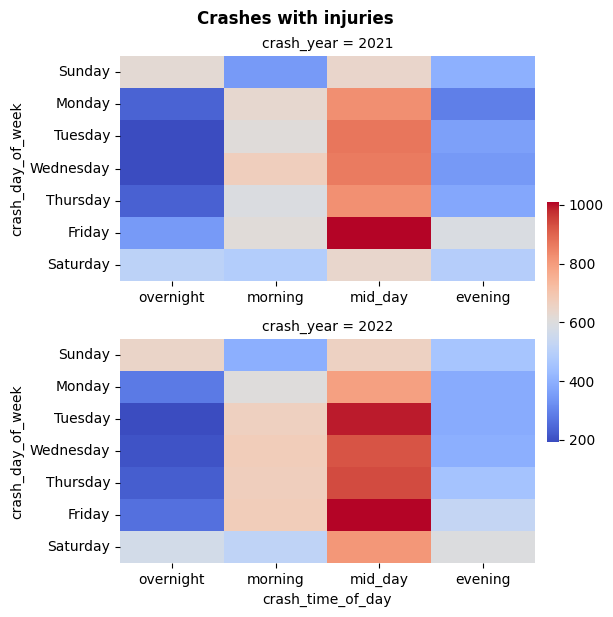

In [ ]:

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot_table(index=args[1], columns=args[0], values=args[2], aggfunc=sum)
    ax = sns.heatmap(d, **kwargs, cmap='coolwarm')
    ax.set_yticklabels(week_days.values(),rotation=0)
    #ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

fg = sns.FacetGrid(crash_df, row='crash_year', aspect=2, sharex=False)
cbar_ax = fg.fig.add_axes([.92, .3, .02, .4],)  # <-- Create a colorbar axes
fg.map_dataframe(draw_heatmap, 'crash_time_of_day', 'crash_day_of_week', 'has_injuries', square = False,
                 cbar_ax=cbar_ax,
                 #vmin=0, vmax=1, center=.5
                )
fg.fig.subplots_adjust(right=.9)
fg.fig.suptitle('Crashes with injuries', y=1.02, fontweight='bold')
plt.show()

# Fiddling with Weekends

In [ ]:
crash_df.query('crash_day_of_week == 1').crash_date.dt.day_name()[:1]

1524    Sunday
Name: crash_date, dtype: object

In [ ]:
crash_df.crash_day_of_week.map(lambda x: 'Weekend' if x in [1,7] else 'Weekday')

0         Weekend
1         Weekend
2         Weekend
3         Weekend
4         Weekend
           ...   
141346    Weekday
141347    Weekday
141348    Weekday
141349    Weekday
141350    Weekday
Name: crash_day_of_week, Length: 139963, dtype: object

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


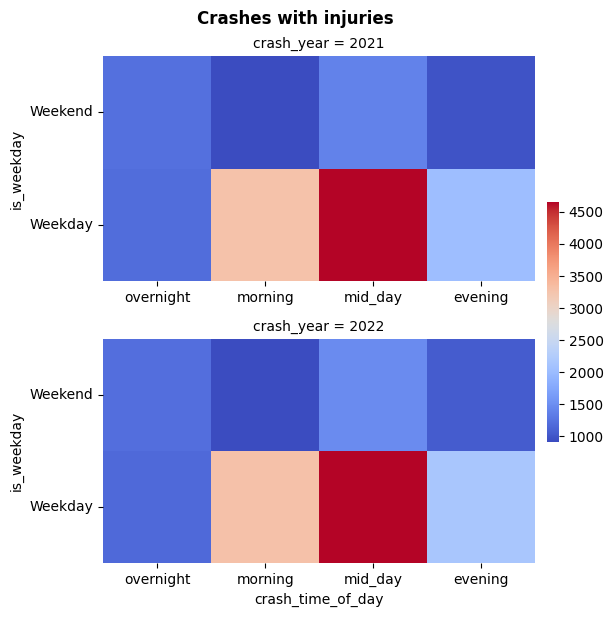

In [ ]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot_table(index=args[1], columns=args[0], values=args[2], aggfunc=sum)
    ax = sns.heatmap(d, **kwargs, cmap='coolwarm')
    ax.set_yticklabels(is_weekday.values(),rotation=0)
    #ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
_ = crash_df
_['is_weekday'] = crash_df.crash_day_of_week.map(lambda x: 0 if x in [1,7] else 1)

fg = sns.FacetGrid(_, row='crash_year',  aspect=2, sharex=False)
cbar_ax = fg.fig.add_axes([.92, .3, .02, .4],)  # <-- Create a colorbar axes
fg.map_dataframe(draw_heatmap, 'crash_time_of_day', 'is_weekday', 'has_injuries', square = False,
                 cbar_ax=cbar_ax,
                 #vmin=0, vmax=1, center=.5
                )
fg.fig.subplots_adjust(right=.9)
fg.fig.suptitle('Crashes with injuries', y=1.02, fontweight='bold')
plt.show()

# Plot Map

In [ ]:
crash_df.groupby(by=['longitude','latitude']).size().reset_index(name='crashes')

,longitude,latitude,crashes
0,-87.936195,41.960823,1
1,-87.933990,41.958988,18
2,-87.933975,42.008057,1
3,-87.933029,41.956558,4
4,-87.928223,41.955547,2
...,...,...,...
86114,-87.524719,41.691692,1
86115,-87.524673,41.702591,3
86116,-87.524643,41.698929,1
86117,-87.524590,41.702572,1


In [ ]:
crash_df_ = crash_df.copy()
crash_df_ = crash_df_.groupby(by=['longitude','latitude','crash_year']).agg(crashes=('has_injuries', 'count'), has_injuries=('has_injuries', 'max'), is_weekday=('is_weekday', 'max')).reset_index().query('crashes > 0')

In [ ]:
crash_df_

,longitude,latitude,crash_year,crashes,has_injuries,is_weekday
0,-87.936195,41.960823,2022,1,0,1
1,-87.933990,41.958988,2021,4,1,1
2,-87.933990,41.958988,2022,14,1,1
3,-87.933975,42.008057,2022,1,0,1
4,-87.933029,41.956558,2022,4,0,1
...,...,...,...,...,...,...
96192,-87.524673,41.702591,2021,1,0,1
96193,-87.524673,41.702591,2022,2,1,1
96194,-87.524643,41.698929,2022,1,0,0
96195,-87.524590,41.702572,2022,1,1,1


In [ ]:
crash_df_.query('crashes>5')

,longitude,latitude,crash_year,crashes,has_injuries,is_weekday
2,-87.933990,41.958988,2022,14,1,1
13,-87.914200,41.953766,2022,18,1,1
19,-87.905312,41.976200,2021,72,1,1
20,-87.905312,41.976200,2022,247,1,1
27,-87.893082,41.955177,2022,7,1,1
...,...,...,...,...,...,...
95850,-87.536606,41.722805,2022,7,0,1
95947,-87.535423,41.713875,2022,9,0,1
96124,-87.528404,41.706264,2022,6,0,1
96160,-87.526489,41.704384,2022,6,1,1


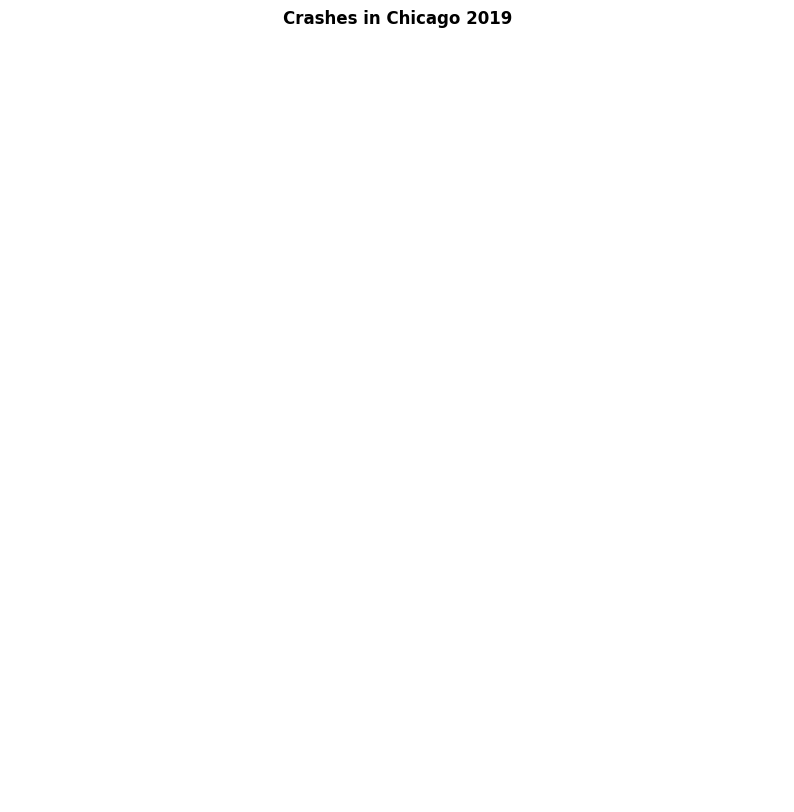

In [ ]:
plt.subplots(figsize=(10,10))
fg = sns.scatterplot(data=crash_df_.query('crash_year == 2019'), x='longitude',y='latitude',
                hue='has_injuries', sizes={1:1,25:12.5,50:25,100:50,200:100}, size_norm=(1,100), size='crashes', alpha=.6)
fg.set_axis_off()
fg.set_title('Crashes in Chicago 2019',fontweight='bold');

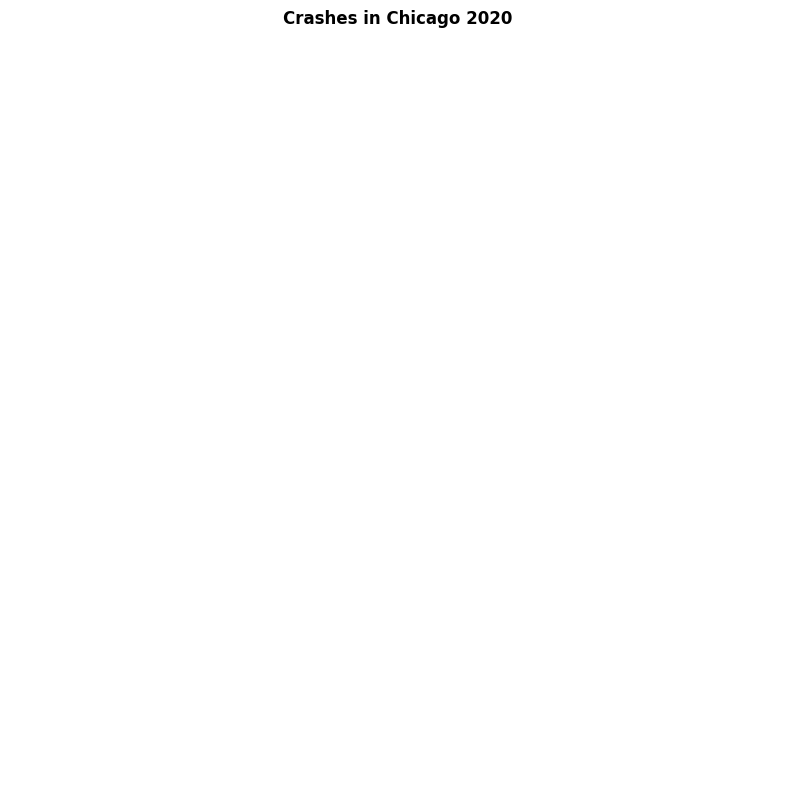

In [ ]:
plt.subplots(figsize=(10,10))
fg = sns.scatterplot(data=crash_df_.query('crash_year == 2020'), x='longitude',y='latitude',
                hue='has_injuries', sizes={1:1,25:12.5,50:25,100:50,200:100}, size_norm=(1,100), size='crashes', alpha=.6)
fg.set_axis_off()
fg.set_title('Crashes in Chicago 2020',fontweight='bold');

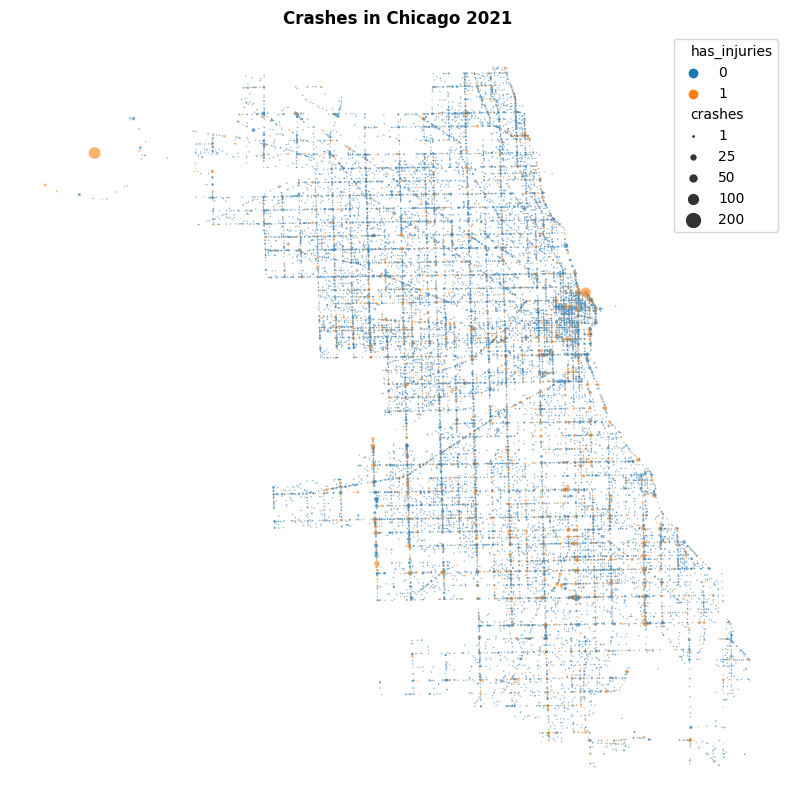

In [ ]:
plt.subplots(figsize=(10,10))
fg = sns.scatterplot(data=crash_df_.query('crash_year == 2021'), x='longitude',y='latitude',
                hue='has_injuries', sizes={1:1,25:12.5,50:25,100:50,200:100}, size_norm=(1,100), size='crashes', alpha=.6)
fg.set_axis_off()
fg.set_title('Crashes in Chicago 2021',fontweight='bold');

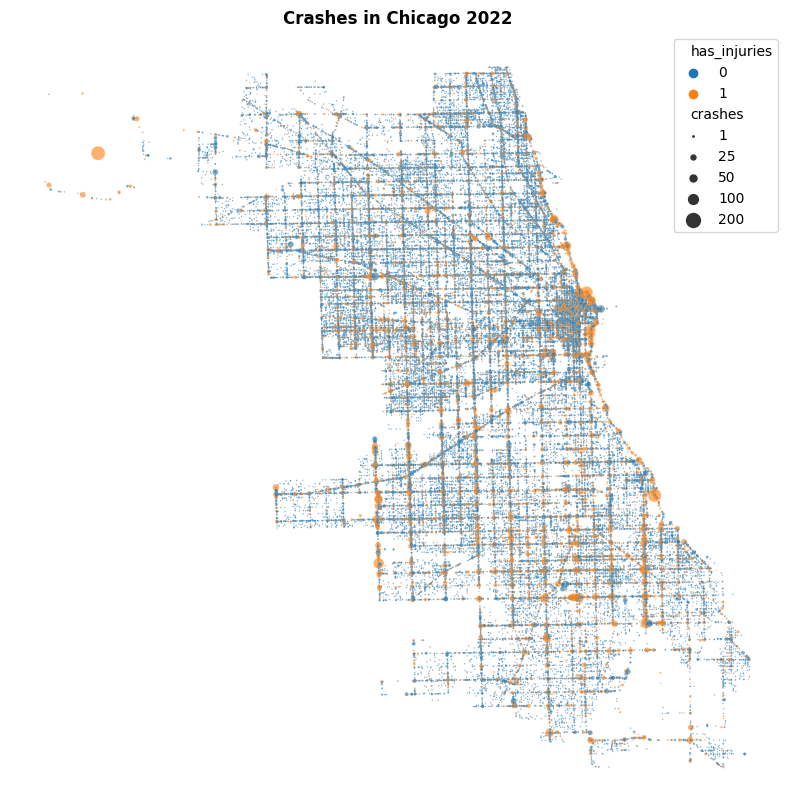

In [ ]:
plt.subplots(figsize=(10,10))
fg = sns.scatterplot(data=crash_df_.query('crash_year == 2022'), x='longitude',y='latitude',
                hue='has_injuries', sizes={1:1,25:12.5,50:25,100:50,200:100}, size_norm=(1,100), size='crashes', alpha=.6)
fg.set_axis_off()
fg.set_title('Crashes in Chicago 2022',fontweight='bold');

In [ ]:
features_names = [
#    'crash_date',
    'crash_year',
    'crash_month',
#    'crash_day_of_week',
#    'crash_hour',
    'crash_time_of_day', # New
    'is_weekday', #New
    'latitude',
    'longitude',
#    'beat_of_occurrence', # Should be considered as categorical, don't scale.
#    'address',
#    'street_no',
#    'street_direction',
#    'street_name',
    'posted_speed_limit',
    'traffic_control_device',
    'device_condition',
    'weather_condition',
    'lighting_condition',
    'trafficway_type',
    'alignment',
    'roadway_surface_cond',
    'road_defect',
    'first_crash_type',
    'prim_contributory_cause',
    'sec_contributory_cause',
    'num_units',
#    'intersection_related_i',
#    'not_right_of_way_i',
#    'hit_and_run_i',
]

target_names = [
    'has_injuries',  # New
#    'has_fatal',  # New
#    'crash_type',
#    'damage',
#    'injuries_total',
#    'injuries_fatal',
#    'injuries_incapacitating',
#    'inj_non_incap',
#    'inj_report_not_evdnt',
#    'injuries_no_indication',
#    'most_severe_injury',
]

all_columns = features_names + target_names
all_columns

['crash_year',
 'crash_month',
 'crash_time_of_day',
 'is_weekday',
 'latitude',
 'longitude',
 'posted_speed_limit',
 'traffic_control_device',
 'device_condition',
 'weather_condition',
 'lighting_condition',
 'trafficway_type',
 'alignment',
 'roadway_surface_cond',
 'road_defect',
 'first_crash_type',
 'prim_contributory_cause',
 'sec_contributory_cause',
 'num_units',
 'has_injuries']

# **Modelling**

In [ ]:
features = crash_df[features_names[0:]].copy() # skip year column
target = crash_df[target_names].has_injuries.copy()

features.shape, target.shape

((139963, 19), (139963,))

## **Encode Categorical**

In [ ]:
features.select_dtypes('category').columns.values

features['crash_month'] = features['crash_month'].astype('category')


In [ ]:
features_dm = pd.get_dummies(features)

In [ ]:
# Split data in to Features X and Target y
X = features_dm
y = target
print('X and y shapes:')
print(X.shape,y.shape,'\n')
print('Target Ratio:')
print(y.value_counts(normalize=True, dropna=False),'\n')

X and y shapes:
(139963, 200) (139963,) 

Target Ratio:
0    0.850746
1    0.149254
Name: has_injuries, dtype: float64 



In [ ]:
# Split data into Train and Test
# We stratify to make sure target representation is kept in the new datasets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2,
#                                                    stratify=y,
                                                    random_state= 2021)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((111970, 200), (27993, 200), (111970,), (27993,))

In [ ]:
print('Training Data:')
print('--------------')
print('X and y shapes:')
print(X_train.shape,y_train.shape,'\n')
print('Target Ratio:')
print(y_train.value_counts(normalize=True, dropna=False),'\n')

Training Data:
--------------
X and y shapes:
(111970, 200) (111970,) 

Target Ratio:
0    0.85046
1    0.14954
Name: has_injuries, dtype: float64 



In [ ]:
print('Testing Data:')
print('-------------')
print('X and y shapes:')
print(X_test.shape,y_test.shape,'\n')
print('Target Ratio:')
print(y_test.value_counts(normalize=True, dropna=False),'\n')

Testing Data:
-------------
X and y shapes:
(27993, 200) (27993,) 

Target Ratio:
0    0.851892
1    0.148108
Name: has_injuries, dtype: float64 



We can see that we have imbalance data so we have to perform Resampling

## **Resampling**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


from sklearn.svm import SVC

from sklearn import metrics

In [ ]:
ros = RandomOverSampler(random_state=2021)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print('Testing Data:')
print('-------------')
print('X and y shapes:')
print(X_train_resampled.shape,y_train_resampled.shape,'\n')
print('Target Ratio:')
print(y_train_resampled.value_counts(normalize=True, dropna=False),'\n')

Testing Data:
-------------
X and y shapes:
(190452, 200) (190452,) 

Target Ratio:
0    0.5
1    0.5
Name: has_injuries, dtype: float64 



In [ ]:
X_train

,crash_year,is_weekday,latitude,longitude,posted_speed_limit,num_units,crash_month_1.0,crash_month_2.0,crash_month_3.0,crash_month_4.0,...,sec_contributory_cause_PHYSICAL CONDITION OF DRIVER,sec_contributory_cause_RELATED TO BUS STOP,sec_contributory_cause_ROAD CONSTRUCTION/MAINTENANCE,sec_contributory_cause_ROAD ENGINEERING/SURFACE/MARKING DEFECTS,sec_contributory_cause_TEXTING,sec_contributory_cause_TURNING RIGHT ON RED,sec_contributory_cause_UNABLE TO DETERMINE,sec_contributory_cause_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED),"sec_contributory_cause_VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)",sec_contributory_cause_WEATHER
133998,2021,1,41.811203,-87.606750,10,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28395,2022,1,41.799568,-87.596565,15,1.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
34779,2022,1,41.895458,-87.726227,25,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34443,2022,1,41.866619,-87.695969,30,2.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
78309,2022,1,41.846130,-87.724762,30,2.0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21383,2022,1,41.879288,-87.649681,30,2.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
91853,2022,1,41.776249,-87.665253,30,2.0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
135091,2021,0,41.788418,-87.673996,30,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
138641,2021,1,41.854305,-87.664787,30,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## **Scaling Data**

In [ ]:
X_train_Scaler = MinMaxScaler().fit(X_train)
X_train_mms = X_train_Scaler.transform(X_train) # mms = MinMaxScaled

X_train_resampled_Scaler = MinMaxScaler().fit(X_train_resampled)
X_train_resampled_mms = X_train_resampled_Scaler.transform(X_train_resampled)

X_test_mms = X_train_Scaler.transform(X_test)
X_test_rs_mms = X_train_resampled_Scaler.transform(X_test)

In [ ]:
X_train_mms

array([[0.        , 1.        , 0.44043584, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.40966505, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.66326675, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.38017554, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.55442897, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.774546  , ..., 0.        , 0.        ,
        0.        ]])

## **Baseline model - Logistic Regression**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.88
Precision: 0.76
Recall: 0.25
F1 Score: 0.38


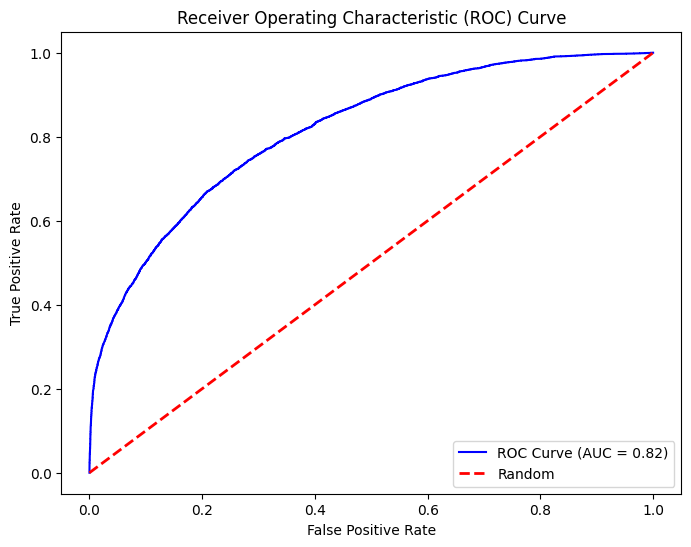

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# Initialize the Logistic Regression model
model = LogisticRegression()

# Train the model
model.fit(X_train_mms, y_train)  # Use X_train_mms for training

# Make predictions on the testing set
y_pred = model.predict(X_test_mms)  # Use X_test_mms for predictions
y_pred_probs = model.predict_proba(X_test_mms)[:, 1]

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy: {:.2f}'.format(accuracy))
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1))

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## **Random Forest**

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Accuracy: 0.87
Precision: 0.88
Recall: 0.14
F1 Score: 0.25


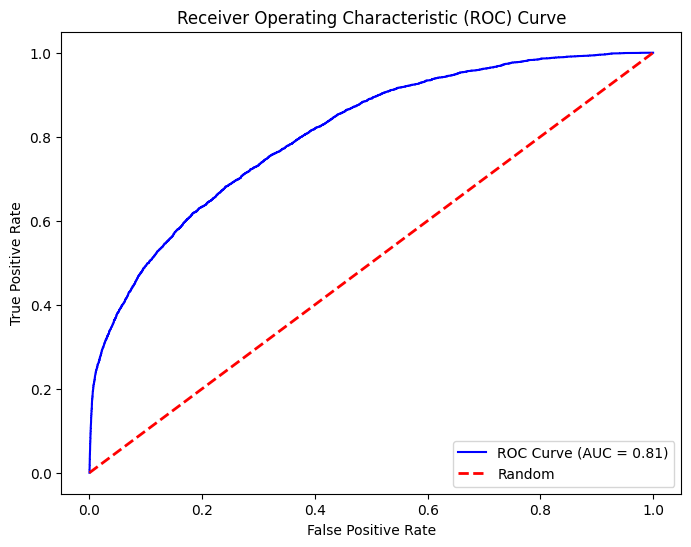

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Initialize the Random Forest Classifier
model = RandomForestClassifier()

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [300],  # Number of trees in the forest
    'max_depth': [10],  # Maximum depth of the tree
    'min_samples_split': [10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [4],  # Minimum number of samples required to be a leaf node
    'max_features': ['auto'],  # Number of features to consider when looking for the best split
    'random_state': [42]  # Seed for random number generation for reproducibility
}

# Perform grid search cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = best_model.predict(X_test)

# Get predicted probabilities of the positive class
y_pred_probs = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy: {:.2f}'.format(accuracy))
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1))

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## **Gradient Boosting Classifier**

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.85
Precision: 0.00
Recall: 0.00
F1 Score: 0.00


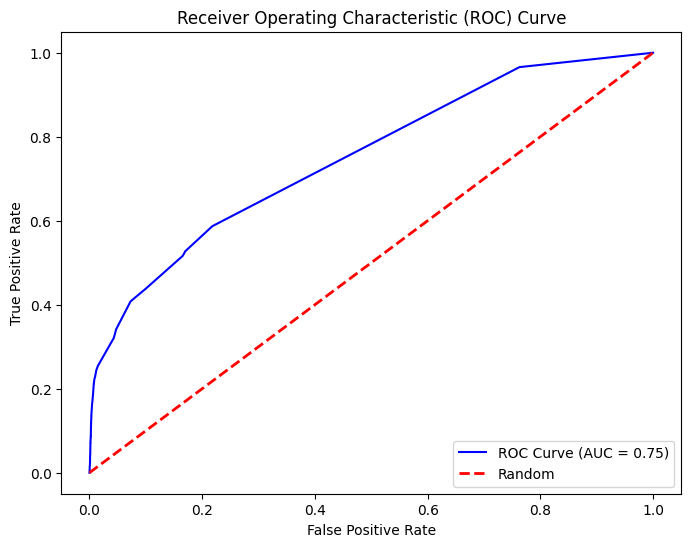

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

# Initialize the Gradient Boosting Classifier
model = GradientBoostingClassifier()

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50],  # Number of boosting stages to perform
    'learning_rate': [0.01],  # Learning rate of the boosting process
    'max_depth': [3],  # Maximum depth of the individual regression estimators
    'min_samples_split': [5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [4],  # Minimum number of samples required to be a leaf node
    'subsample': [0.8],  # Fraction of samples to be used for fitting the individual base learners
    'random_state': [42]  # Seed for random number generation for reproducibility
}

# Perform grid search cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_model = GradientBoostingClassifier(**best_params)
best_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = best_model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy: {:.2f}'.format(accuracy))
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1))

# Compute ROC curve and AUC
y_pred_probs = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## **SGD Classifier**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy: 0.69
Precision: 0.29
Recall: 0.78
F1 Score: 0.42


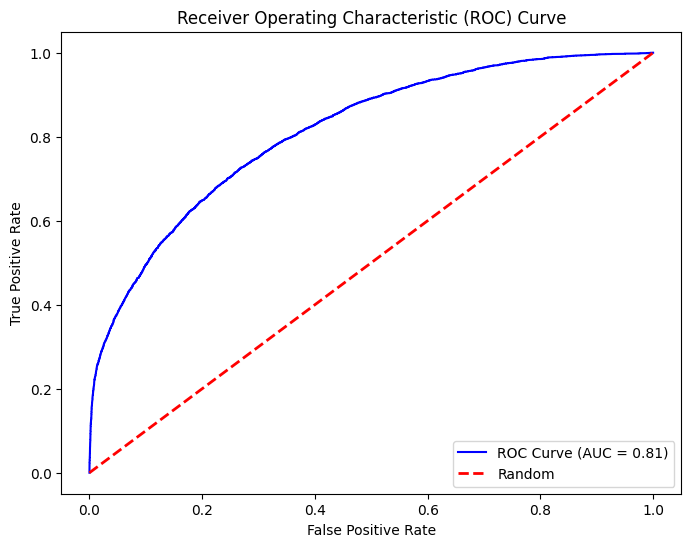

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize the SGD Classifier
model = SGDClassifier(loss='log', random_state=42)  # 'log' for logistic regression

# Train the model
model.fit(X_train_resampled_mms, y_train_resampled)

# Make predictions on the testing set
y_pred = model.predict(X_test_mms)

# Calculate prediction probabilities for ROC curve
y_pred_probs = model.decision_function(X_test_mms)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy: {:.2f}'.format(accuracy))
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1))

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# KNN

Optimized KNN Model Performance:
Accuracy: 0.85
Precision: 1.00
Recall: 0.00
F1 Score: 0.00
AUC-PR: 0.72


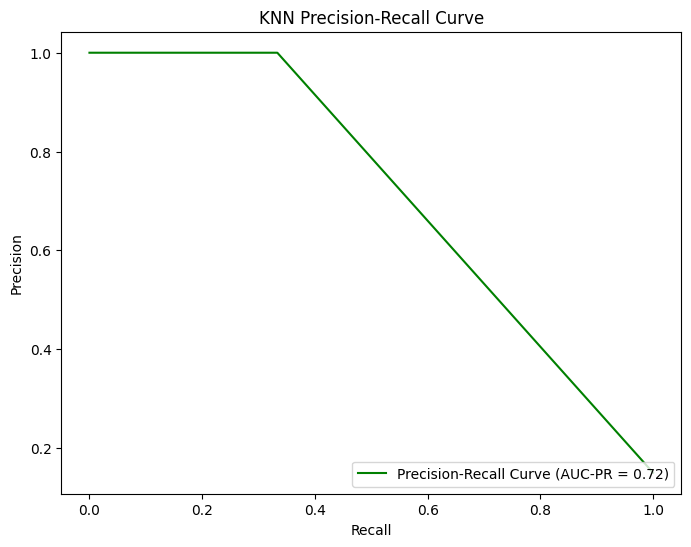

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Generate a synthetic dataset with imbalanced classes for illustration
X, y = make_classification(n_samples=100, n_features=3, n_informative=2, n_redundant=0, n_classes=2, weights=[0.9, 0.1], random_state=42)

# Introduce some missing values in the features
X[::10, :] = np.nan

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize KNNImputer to replace missing values
knn_imputer = KNNImputer(n_neighbors=3)

# Fit and transform the imputer on the training data
X_train_imputed = knn_imputer.fit_transform(X_train)

# Transform the test data using the same imputer
X_test_imputed = knn_imputer.transform(X_test)

# Initialize the KNN Classifier
knn_model = KNeighborsClassifier(n_neighbors=3)

# Train the KNN model on the imputed training data
knn_model.fit(X_train_imputed, y_train)

# Get predicted probabilities for the positive class
y_prob_knn = knn_model.predict_proba(X_test_imputed)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_knn)

# Compute Area Under the Precision-Recall Curve (AUC-PR)
auc_pr = auc(recall, precision)

# Find the threshold that maximizes F1 score
best_f1_index = np.argmax(2 * precision * recall / (precision + recall))
best_threshold = thresholds[best_f1_index]

# Use the optimized threshold for predictions
y_pred_knn_optimized = (y_prob_knn > best_threshold).astype(int)

# Print the optimized KNN model performance metrics
accuracy_knn_optimized = accuracy_score(y_test, y_pred_knn_optimized)
precision_knn_optimized = precision_score(y_test, y_pred_knn_optimized, zero_division=1)
recall_knn_optimized = recall_score(y_test, y_pred_knn_optimized, zero_division=1)
f1_knn_optimized = f1_score(y_test, y_pred_knn_optimized, zero_division=1)

print('Optimized KNN Model Performance:')
print('Accuracy: {:.2f}'.format(accuracy_knn_optimized))
print('Precision: {:.2f}'.format(precision_knn_optimized))
print('Recall: {:.2f}'.format(recall_knn_optimized))
print('F1 Score: {:.2f}'.format(f1_knn_optimized))
print('AUC-PR: {:.2f}'.format(auc_pr))

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve (AUC-PR = {:.2f})'.format(auc_pr))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('KNN Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

SVM Model Performance:
Accuracy: 0.95
Precision: 1.00
Recall: 0.67
F1 Score: 0.80


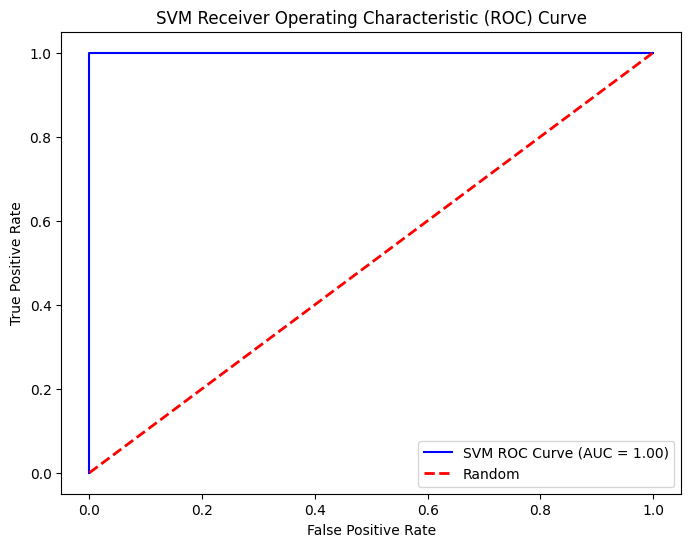

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# Generate a synthetic dataset with imbalanced classes for illustration
X, y = make_classification(n_samples=100, n_features=3, n_informative=2, n_redundant=0, n_classes=2, weights=[0.9, 0.1], random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SimpleImputer to replace missing values with the mean (you can choose a different strategy)
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on the training data
X_train_imputed = imputer.fit_transform(X_train)

# Transform the test data using the same imputer
X_test_imputed = imputer.transform(X_test)

# Initialize the SVM Classifier
svm_model = SVC(probability=True, random_state=42)

# Train the SVM model on the imputed training data
svm_model.fit(X_train_imputed, y_train)

# Make predictions on the testing set
y_pred_svm = svm_model.predict(X_test_imputed)

# Evaluate the SVM model performance
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, zero_division=1)
recall_svm = recall_score(y_test, y_pred_svm, zero_division=1)
f1_svm = f1_score(y_test, y_pred_svm, zero_division=1)

# Print the SVM model performance metrics
print('SVM Model Performance:')
print('Accuracy: {:.2f}'.format(accuracy_svm))
print('Precision: {:.2f}'.format(precision_svm))
print('Recall: {:.2f}'.format(recall_svm))
print('F1 Score: {:.2f}'.format(f1_svm))

# Compute ROC curve and AUC for SVM model
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm_model.predict_proba(X_test_imputed)[:, 1])
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve for SVM model
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='blue', label='SVM ROC Curve (AUC = {:.2f})'.format(roc_auc_svm))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
